In [1]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt

c:\Users\ayera\OneDrive\Desktop\recommender_system_private_pc\recommender_systems_private\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load Data

In [2]:
# Download dataset
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ayera\.cache\kagglehub\datasets\retailrocket\ecommerce-dataset\versions\2


In [3]:
# Load raw events CSV
events = pd.read_csv(os.path.join(path, "events.csv"))
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
# Load item properties CSVs
item_properties1 = pd.read_csv(os.path.join(path, "item_properties_part1.csv"))
item_properties2 = pd.read_csv(os.path.join(path, "item_properties_part2.csv"))

# Concatenate parts
item_props = pd.concat([item_properties1, item_properties2], ignore_index=True)
item_props.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


# 2. Event Overview

In [5]:
# Display dataframe info
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [6]:
# Calculate missing value percentage
events.isnull().sum() / len(events) * 100

timestamp         0.00000
visitorid         0.00000
event             0.00000
itemid            0.00000
transactionid    99.18519
dtype: float64

In [7]:
# Convert timestamps from milliseconds to datetime
if "dt" not in events.columns:
    if "timestamp" not in events.columns:
        raise ValueError("events must have either 'dt' or 'timestamp'.")
    events["dt"] = pd.to_datetime(events["timestamp"], unit="ms", utc=True)

print("events dt range:", events["dt"].min(), "→", events["dt"].max())

events dt range: 2015-05-03 03:00:04.384000+00:00 → 2015-09-18 02:59:47.788000+00:00


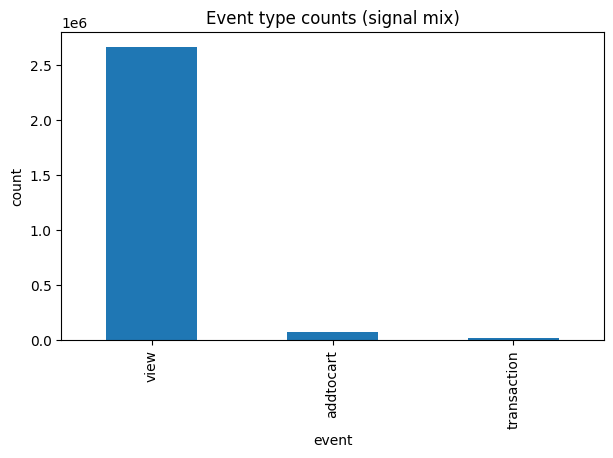

,count
event,
view,2664312
addtocart,69332
transaction,22457


,share
event,
view,0.966696
addtocart,0.025156
transaction,0.008148


In [8]:
# Count event types
event_counts = events["event"].astype(str).value_counts()

# Plot event counts
plt.figure(figsize=(7,4))
event_counts.plot(kind="bar")
plt.title("Event type counts (signal mix)")
plt.ylabel("count")
plt.show()

# Display counts and shares
display(event_counts.to_frame("count"))
display((event_counts / event_counts.sum()).to_frame("share"))

In [9]:
# Calculate basic statistics
n_events = len(events)
n_users = events["visitorid"].nunique()
n_items = events["itemid"].nunique()

# Print statistics
print("Total events:", n_events)
print("Unique users:", n_users)
print("Unique items:", n_items)
print("Avg events per user:", n_events / n_users)
print("Avg events per item:", n_events / n_items)

Total events: 2756101
Unique users: 1407580
Unique items: 235061
Avg events per user: 1.9580421716705267
Avg events per item: 11.725045839165153


# 3. User Activity Analysis

,value
0.50,1.0
0.90,3.0
0.95,5.0
0.99,13.0


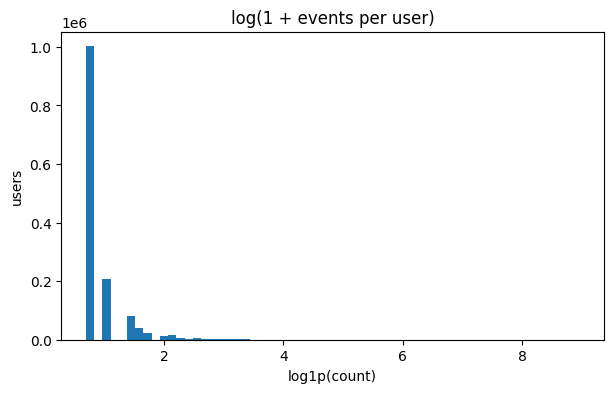

% users with >= 2 events: 0.28845252134869775
% users with >= 5 events: 0.05798604697423947
% users with >= 10 events: 0.016511317296352607


In [10]:
def qtable(s, qs=(0.5, 0.9, 0.95, 0.99)):
    # Return quantiles
    return s.quantile(list(qs)).to_frame("value")

# Count events per user
user_cnt = events.groupby("visitorid").size()

display(qtable(user_cnt))

# Plot histogram of user event counts
plt.figure(figsize=(7,4))
plt.hist(np.log1p(user_cnt), bins=60)
plt.title("log(1 + events per user)")
plt.xlabel("log1p(count)")
plt.ylabel("users")
plt.show()

# Print user engagement stats
print("% users with >= 2 events:", float((user_cnt >= 2).mean()))
print("% users with >= 5 events:", float((user_cnt >= 5).mean()))
print("% users with >= 10 events:", float((user_cnt >= 10).mean()))

# 4. Data Quality Checks

In [11]:
# Define duplicate key
dup_key = ["visitorid", "itemid", "event", "timestamp"] if "timestamp" in events.columns else ["visitorid", "itemid", "event", "dt"]

# Count duplicates
dup_count = events.duplicated(subset=dup_key).sum()

print("Exact duplicates:", int(dup_count))
print("Duplicate rate:", float(dup_count / len(events)))

Exact duplicates: 460
Duplicate rate: 0.00016690244660845158


In [12]:
# Identify transaction rows
is_tx = events["event"].astype(str).eq("transaction")
tx_rows = int(is_tx.sum())

# Check for missing transaction IDs
if "transactionid" in events.columns and tx_rows > 0:
    missing_txid = float(events.loc[is_tx, "transactionid"].isna().mean())
    print("Transaction rows:", tx_rows)
    print("Transaction rows missing transactionid (should be ~0):", missing_txid)
else:
    print("No transactionid column or no transaction rows found.")

Transaction rows: 22457
Transaction rows missing transactionid (should be ~0): 0.0


# 5. Temporal Analysis

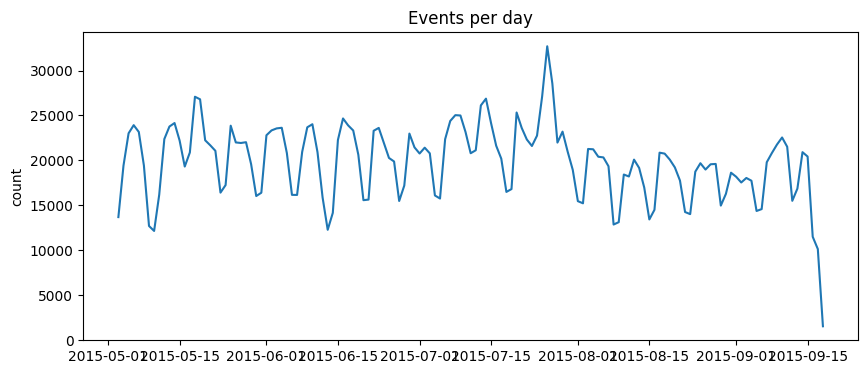

,value
count,139.000000
mean,19828.064748
std,4170.654332
min,1528.000000
25%,16831.500000
50%,20621.000000
75%,22461.000000
max,32703.000000


In [13]:
# Resample events by day
events_per_day = events.set_index("dt").resample("D").size()

# Plot events per day
plt.figure(figsize=(10,4))
plt.plot(events_per_day.index, events_per_day.values)
plt.title("Events per day")
plt.ylabel("count")
plt.show()

display(events_per_day.describe().to_frame("value"))

C:\Users\ayera\AppData\Local\Temp\ipykernel_3720\1561784263.py:6: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


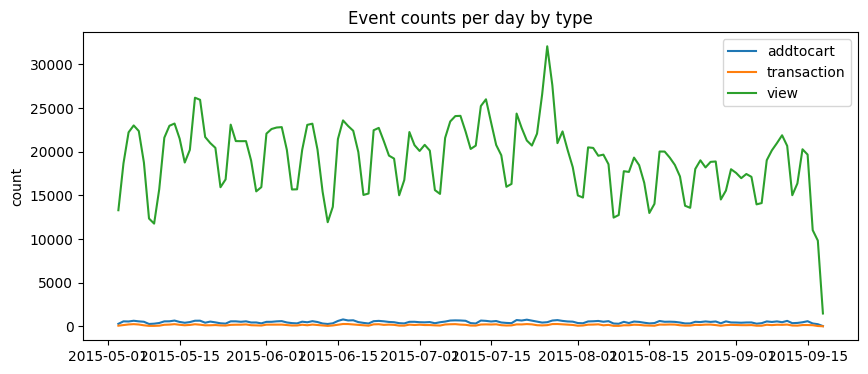

In [14]:
# Resample events by day and type
events_by_day_type = (events.assign(event=events["event"].astype(str))
                        .set_index("dt")
                        .groupby("event")
                        .resample("D")
                        .size()
                        .unstack(0)
                        .fillna(0))

# Plot events by type
plt.figure(figsize=(10,4))
for col in events_by_day_type.columns:
    plt.plot(events_by_day_type.index, events_by_day_type[col].values, label=col)
plt.title("Event counts per day by type")
plt.ylabel("count")
plt.legend()
plt.show()

# 6. Item Properties Overview

In [15]:
# Display item properties info
item_props.info()
item_props.isnull().sum() / len(item_props) * 100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


timestamp    0.0
itemid       0.0
property     0.0
value        0.0
dtype: float64

In [16]:
# Convert timestamps to datetime
if "dt" not in item_props.columns:
    if "timestamp" not in item_props.columns:
        raise ValueError("item_props must have either 'dt' or 'timestamp'.")
    item_props["dt"] = pd.to_datetime(item_props["timestamp"], unit="ms", utc=True)

print("item_props dt range:", item_props["dt"].min(), "→", item_props["dt"].max())

item_props dt range: 2015-05-10 03:00:00+00:00 → 2015-09-13 03:00:00+00:00


In [17]:
# Get unique items
event_items = pd.Index(events["itemid"].unique())
prop_items = pd.Index(item_props["itemid"].unique())

print("Unique event items:", len(event_items))
print("Unique items with properties:", len(prop_items))

# Calculate overlap
print("Share of event items present in item_props:", float(event_items.isin(prop_items).mean()))
print("Share of event rows whose item has properties:", float(events["itemid"].isin(prop_items).mean()))

Unique event items: 235061
Unique items with properties: 417053
Share of event items present in item_props: 0.7880762865809301
Share of event rows whose item has properties: 0.9072657351816933


# 7. Property Value Statistics

,value
0.50,42.0
0.90,83.0
0.95,110.0
0.99,133.0


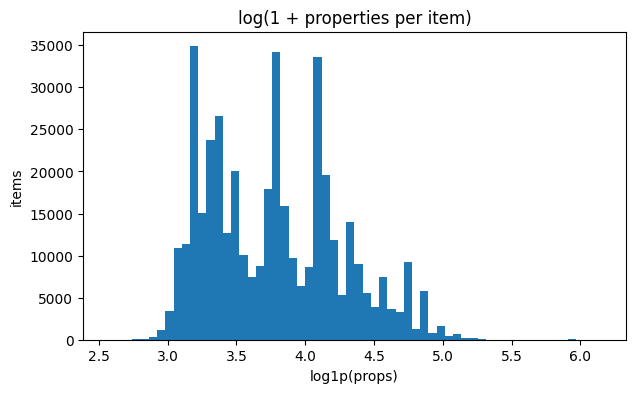

In [18]:
# Count properties per item
props_per_item = item_props.groupby("itemid").size()

display(qtable(props_per_item))

# Plot histogram of properties per item
plt.figure(figsize=(7,4))
plt.hist(np.log1p(props_per_item), bins=60)
plt.title("log(1 + properties per item)")
plt.xlabel("log1p(props)")
plt.ylabel("items")
plt.show()

In [19]:
# Get top properties
top_props = item_props["property"].astype(str).value_counts().head(20)
display(top_props.to_frame("count"))

# Calculate unique values per property
val_card = (item_props.assign(property=item_props["property"].astype(str),
                            value=item_props["value"].astype(str))
                    .groupby("property")["value"].nunique()
                    .sort_values(ascending=False))

display(val_card.head(20).to_frame("unique_values"))

,count
property,
888,3000398
790,1790516
available,1503639
categoryid,788214
6,631471
283,597419
776,574220
678,481966
364,476486


,unique_values
property,
888,454723
364,420554
917,400893
283,333165
776,328837
202,279313
575,47054
790,33052
810,8425


In [20]:
# Prepare temporary dataframe
tmp = item_props.copy()
tmp["property"] = tmp["property"].astype(str)
tmp["value"] = tmp["value"].astype(str)

# Count unique values per item property
values_per_itemprop = tmp.groupby(["itemid", "property"])["value"].nunique()

display(values_per_itemprop.quantile([0.5, 0.9, 0.95, 0.99]).to_frame("unique_values_per_(item,property)"))
print("Share of (item,property) pairs with >1 value over time:", float((values_per_itemprop > 1).mean()))

,"unique_values_per_(item,property)"
0.50,1.0
0.90,1.0
0.95,1.0
0.99,2.0


Share of (item,property) pairs with >1 value over time: 0.04230905277272707
